# Generate Training Data
## Preparation

In [1]:
from scapy.all import *
import pandas as pd
import numpy as np
from tqdm import tqdm

In [122]:
import logging

logging.basicConfig(level=logging.DEBUG)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

In [3]:
# Formatters for displaying pandas data tables with columns of (lists of) scapy packets

def packet_list_fmt(lst):
    return f"{len(lst)} packets"

def packet_fmt(pkt):
    return pkt[DNS].summary()

In [4]:
ALGO_NAME = {
    0: 'unsigned',
    0: 0,
    5: 'rsasha1', 
    7: 'rsasha1nsec3sha1', 
    8: 'rsasha256', 
    10: 'rsasha512',
    13: 'ecdsap256sha256', 
    14: 'ecdsap384sha384', 
    15: 'ed25519', 
    16: 'ed448',
}
ALGO_NUM = {name: num for num, name in ALGO_NAME.items()}

In [5]:
# retrieve information encoded in DNS qnames

def split_qname(row):
    qname = row['qname']
    parts = qname.decode('ascii').split(".")
    try:
        if ".".join(parts[-3:]) == "dnstb.net.":
            if '-' not in parts[-4]:
                # this qname has a label directly under dnstb.net, store it
                # then remove to be compatible with qnames without label
                qlabel = parts[-4]
                del parts[-4]
            else:
                qlabel = ''
            
            resolver_parts = parts[-5].split("-")            
            if parts[-4] == 'unsigned':
                return {
                    'zone_algorithm': 0,
                    'zone_keysize': 0,
                    'zone_nsec': 0,
                    'zone_status': parts[-4],
                    'resolver': resolver_parts[1],
                    'qlabel': qlabel,                    
                }
            else:
                zone_parts = parts[-4].split("-")
                return {
                    'zone_algorithm': zone_parts[0],
                    'zone_keysize': zone_parts[1],
                    'zone_nsec': zone_parts[2],
                    'zone_status': zone_parts[3],
                    'resolver': resolver_parts[1],
                    'qlabel': qlabel,
                }
    except IndexError:
        logging.warning(f"could not split qname {qname} into meaningful information")
        return {
            'zone_algorithm': None,
            'zone_keysize': None,
            'zone_nsec': None,
            'zone_status': None,
            'resolver': None,
            'qlabel': None,
        }
    logging.warning(f"Could not split qname: {qname}")
    return {
        'zone_algorithm': None,
        'zone_keysize': None,
        'zone_nsec': None,
        'zone_status': None,
        'resolver': None,
        'qlabel': None,
    }

## Load Data

In [1]:
%%bash 

mkdir -p ../traffic
rsync -aP root@ns1.adnssec.dedyn.io:/var/log/tcplogger/ ../traffic/

receiving incremental file list
./
eth0-20210621232559.pcap
 13,263,153,510 100%   10.67MB/s    0:19:45 (xfr#1, to-chk=2/4)
eth1-20210621232559.pcap
          8,344 100%    9.12kB/s    0:00:00 (xfr#2, to-chk=1/4)
interfaces
             10 100%    0.01kB/s    0:00:00 (xfr#3, to-chk=0/4)


In [6]:
# load the traffic logs
# TODO: loop over available traffic dumps

c_logs = filter(lambda s: s, """
tcpdump_opn_cisco-umbrella_vpn0_20210617014323.pcap
tcpdump_opn_cloudflare_vpn0_20210617014323.pcap
tcpdump_opn_comodo-secure-dns_vpn0_20210617014323.pcap
tcpdump_opn_cznic-odvr_vpn0_20210617014323.pcap
tcpdump_opn_freenom-world_vpn0_20210617014323.pcap
tcpdump_opn_google_vpn0_20210617014323.pcap
tcpdump_opn_neustar-free-recursive_vpn0_20210617014323.pcap
tcpdump_opn_norton-connectsafe_vpn0_20210617014323.pcap
tcpdump_opn_opennic_vpn0_20210617014323.pcap
tcpdump_opn_oracle-dyn_vpn0_20210617014323.pcap
tcpdump_opn_quad9_vpn0_20210617014323.pcap

tcpdump_lab_bind9113_vpn0_20210617024144.pcap
tcpdump_lab_kresd532_vpn0_20210617024144.pcap
tcpdump_lab_powerdns460_vpn0_20210617024144.pcap
tcpdump_lab_unbound167_vpn0_20210617024144.pcap
tcpdump_lab_ws2012r2_vpn0_20210617024144.pcap
tcpdump_lab_ws2012_vpn0_20210617024144.pcap
tcpdump_lab_ws2016_vpn0_20210617024144.pcap
tcpdump_lab_ws2019_vpn0_20210617024144.pcap
""".split("\n"))


c_packets = reduce(lambda a,b: a + b, (rdpcap(f"../traffic/{f}") for f in c_logs))

In [7]:
# using the client logs, get a list of queries

queries = []
queries_by_id = {}
dropped = []

for p in c_packets:
    try:
        p[DNS]
    except IndexError:
        logging.warning(f'Broken DNS packet at time {p.time}?')
        dropped.append(p)
        continue
    if p[DNS].qr == 0:
        # query
        qid = p[DNS].id
        q = {
            'id': qid,
            'qname': p[DNS].qd.qname,
            'tag': p[DNS].qd.qname.split(b'.', 1)[0],
            'started': p.time,
            'client_packets': [p],
            'server_packets': [],
        }
        queries.append(q)
        queries_by_id[qid] = q
    else:
        # response
        qid = p[DNS].id
        try:
            queries_by_id[qid]
        except KeyError:
            logging.warning(f"Response without query at time {p.time}")
            continue
        queries_by_id[qid]['finished'] = p.time
        queries_by_id[qid]['client_packets'].append(p)
    
queries = pd.DataFrame(queries)
queries['qname_parts'] = queries.apply(split_qname, axis=1)
for key in ['zone_algorithm', 'zone_keysize', 'zone_nsec', 'zone_status', 'resolver']:
    queries[key] = queries.apply(lambda row: row['qname_parts'][key], axis=1)
del queries['qname_parts']

first_query_time, last_query_time = queries['started'].min(), queries['finished'].max()

In [8]:
len(queries)

2686

In [9]:
len(dropped)

276

In [10]:
from datetime import datetime
import math

In [11]:
datetime.fromtimestamp(math.floor(first_query_time)), datetime.fromtimestamp(math.ceil(last_query_time))

(datetime.datetime(2021, 6, 17, 1, 43, 25),
 datetime.datetime(2021, 6, 17, 2, 50, 6))

In [12]:
%%bash

cd ../traffic
editcap -A "2021-06-17 01:43:25" -B "2021-06-17 02:50:06" eth0-20210616183851.pcap eth0-20210616183851.filtered.pcap

In [13]:
%%bash

ls -lh ../traffic/eth0*

-rw-r----- 1 nils nils   24 Jun  4 13:48 ../traffic/eth0-20210604114854.pcap
-rw-r----- 1 nils nils  13K Jun  4 13:51 ../traffic/eth0-20210604114855.pcap
-rw-r----- 1 nils nils   24 Jun  4 13:51 ../traffic/eth0-20210604115148.pcap
-rw-r----- 1 nils nils 5.4K Jun  4 13:57 ../traffic/eth0-20210604115149.pcap
-rw-r----- 1 nils nils   24 Jun  4 13:57 ../traffic/eth0-20210604115751.pcap
-rw-r----- 1 nils nils 3.0M Jun  7 10:49 ../traffic/eth0-20210604115752.pcap
-rw-r----- 1 nils nils   24 Jun  7 10:49 ../traffic/eth0-20210607084932.pcap
-rw-r----- 1 nils nils   24 Jun  7 10:49 ../traffic/eth0-20210607084933.pcap
-rw-r----- 1 nils nils   24 Jun  7 10:49 ../traffic/eth0-20210607084940.pcap
-rw-r----- 1 nils nils  13M Jun 11 08:16 ../traffic/eth0-20210607084941.pcap
-rw-r----- 1 nils nils   24 Jun 11 11:29 ../traffic/eth0-20210611092938.pcap
-rw-r----- 1 nils nils 1.6K Jun 11 11:32 ../traffic/eth0-20210611092939.pcap
-rw-r----- 1 nils nils 122K Jun 11 14:03 ../traffic/eth0-20210611093249.pcap

In [14]:
s_packets = rdpcap('../traffic/eth0-20210616183851.filtered.pcap')

In [15]:
len(s_packets)

157399

## Match Client and Server Data

In [16]:
# using the server logs, match packets captured at the server to the client's questions

candidates = []

for p in tqdm(s_packets):
    if queries['started'].min() <= p.time <= queries['finished'].max():
        try:
            p_dns = tag = p[DNS]
        except IndexError:
            logging.warning(f'packet with timestamp {p.time} could not be parsed as DNS packet')
            continue
        
        if p_dns.qd is None:
            logging.warning(f'packet with timestamp {p.time} did not contain a query name')
            continue
        
        tag = p_dns.qd.qname.split(b'.', 1)[0]
        candidate_queries = (queries['started'] <= p.time) & (p.time <= queries['finished']) & (queries['tag'] == tag)
        if sum(candidate_queries) == 0:
            continue
        elif sum(candidate_queries) == 1:
            queries[candidate_queries].iloc[0]['server_packets'].append(p)
        else:
            logging.warning(f'Initial DNS query not uniquely identified for packet with time stamp {p.time}')
        

 46%|████▌     | 72391/157399 [02:45<03:13, 438.85it/s]WARNING:root:packet with timestamp 1623889623.167245 could not be parsed as DNS packet


 65%|██████▍   | 101602/157399 [03:49<01:58, 472.80it/s]WARNING:root:packet with timestamp 1623889860.100648 could not be parsed as DNS packet


 82%|████████▏ | 128771/157399 [04:48<01:19, 359.83it/s]WARNING:root:packet with timestamp 1623890068.040034 could not be parsed as DNS packet


100%|██████████| 157399/157399 [05:56<00:00, 441.04it/s]


## Clean and Organize Data

In [17]:
# drop rows that do not have exactly two client packets

queries['num_client_packets'] = queries.apply(lambda row: len(row['client_packets']), axis=1)
drop = queries['num_client_packets'] != 2
if sum(drop):
    logging.warning(f'Dropping {sum(drop)} of {len(queries)} queries as they do not have exactly two client packets')
    for count, num in zip(*np.unique(queries['num_client_packets'], return_counts=True)):
        if count == 2: continue
        logging.warning(f'- {num} queries had {count} client packet(s)')
queries = queries.drop(queries[drop].index)

queries['client_query'] = queries.apply(lambda row: row['client_packets'][0], axis=1)
queries['client_response'] = queries.apply(lambda row: row['client_packets'][1], axis=1)
del queries['client_packets']

In [18]:
queries['client_response_rcode'] = queries.apply(lambda row: row['client_response'].rcode, axis=1)
queries['client_response_ad'] = queries.apply(lambda row: row['client_response'].ad, axis=1)

In [19]:
# TODO: select server packet(s) for feature extraction

def take_first_query(packet_list):
    queries = filter(lambda p: p[DNS].qr == 0, packet_list)
    try:
        return next(iter(queries))
    except StopIteration:
        return None

queries['num_server_packets'] = queries.apply(lambda row: len(row['server_packets']), axis=1)
queries['server_query'] = queries.apply(lambda row: take_first_query(row['server_packets']), axis=1)

In [20]:
drop = queries['server_query'].isnull()
if sum(drop):
    logging.warning(f"Dropping {sum(drop)} of {len(queries)} queries as corresponding server packets could not be found!")
    queries = queries.drop(queries[drop].index)

In [21]:
queries['validated_response'] = (queries['client_response_rcode'] == 0) & (queries['client_response_ad'] == 1)

In [22]:
queries['num_server_packets'].min(), queries['num_server_packets'].mean(), queries['num_server_packets'].max(), queries['num_server_packets'].unique()

(2,
 2.482638888888889,
 46,
 array([ 2,  4,  6, 22, 14, 12,  8, 16, 26, 46, 20, 24, 28, 18]))

## Extract Features and Label

In [23]:
# set the label

queries['label_rcode'] = queries['client_response_rcode']
queries['label_resolver'] = queries['resolver']
queries['label_rcode0andad1'] = queries['validated_response']

In [105]:
# set some features

queries['feature_ip_ttl'] = queries.apply(lambda row: row['server_query'][IP].ttl, axis=1)
queries['feature_ip_src'] = queries.apply(lambda row: row['server_query'][IP].src, axis=1)
queries['feature_ip_proto'] = queries.apply(lambda row: row['server_query'][IP].proto, axis=1)
queries['feature_ip_df'] = queries.apply(lambda row: row['server_query'][IP].flags == 2, axis=1)
queries['feature_ip_ihl'] = queries.apply(lambda row: row['server_query'][IP].ihl, axis=1)
queries['feature_ip_id_is_zero'] = queries.apply(lambda row: row['server_query'][IP].id == 0, axis=1)
queries['feature_udp_len'] = queries.apply(lambda row: row['server_query'][UDP].len, axis=1)
queries['feature_dns_qr'] = queries.apply(lambda row: row['server_query'][DNS].qr, axis=1)
queries['feature_dns_opcode'] = queries.apply(lambda row: row['server_query'][DNS].opcode, axis=1)
queries['feature_dns_aa'] = queries.apply(lambda row: row['server_query'][DNS].aa, axis=1)
queries['feature_dns_tc'] = queries.apply(lambda row: row['server_query'][DNS].tc, axis=1)
queries['feature_dns_rd'] = queries.apply(lambda row: row['server_query'][DNS].rd, axis=1)
queries['feature_dns_ra'] = queries.apply(lambda row: row['server_query'][DNS].ra, axis=1)
queries['feature_dns_z'] = queries.apply(lambda row: row['server_query'][DNS].z, axis=1)
queries['feature_dns_cd'] = queries.apply(lambda row: row['server_query'][DNS].cd, axis=1)
queries['feature_dns_rcode'] = queries.apply(lambda row: row['server_query'][DNS].rcode, axis=1)
queries['feature_dns_qdcount'] = queries.apply(lambda row: row['server_query'][DNS].qdcount, axis=1)
queries['feature_dns_ancount'] = queries.apply(lambda row: row['server_query'][DNS].ancount, axis=1)
queries['feature_dns_nscount'] = queries.apply(lambda row: row['server_query'][DNS].nscount, axis=1)
queries['feature_dns_arcount'] = queries.apply(lambda row: row['server_query'][DNS].arcount, axis=1)
queries['feature_dns_edns_requestors_udp_payload_size'] = queries.apply(lambda row: row['server_query'][DNS].ar.rclass, axis=1)
queries['feature_dns_0x20'] = queries.apply(lambda row: row['server_query'][DNS].qd.qname.lower() != row['server_query'][DNS].qd.qname and row['server_query'][DNS].qd.qname.upper() != row['server_query'][DNS].qd.qname, axis=1)
queries['feature_dns_edns_num_extra_attributes'] = queries.apply(lambda row: len(row['server_query'][DNS].ar.rdata), axis=1)
assert queries['feature_dns_edns_num_extra_attributes'].max() == 1
queries['feature_dns_edns_optcode'] = queries.apply(lambda row: row['server_query'][DNS].ar.rdata[0].optcode if row['feature_dns_edns_num_extra_attributes'] == 1 else -1, axis=1)
assert set(queries['feature_dns_edns_optcode'].unique()) == {-1, 8, 10}
queries['feature_dns_edns_cookie'] = queries['feature_dns_edns_optcode'] == 10
queries['feature_dns_edns_subnet'] = queries['feature_dns_edns_optcode'] == 8
del queries['feature_dns_edns_num_extra_attributes']
del queries['feature_dns_edns_optcode']
#queries['feature_zone_algorithm'] = queries['zone_algorithm']
#queries['feature_zone_keysize'] = queries['zone_keysize']
#queries['feature_zone_nsec'] = queries['zone_nsec']

In [106]:
for algo in queries['zone_algorithm'].unique():
    print(f'++++{algo}++++')
    for c in filter(lambda c: c.startswith('feature_'), queries.keys()):
        u = np.unique(queries[(queries['zone_algorithm'] == algo)][c], return_counts=True)
        if len(u[0]) > 1:
            print(f"{c}: {len(u[0])} unique values")

++++ecdsap256sha256++++
feature_ip_ttl: 9 unique values
feature_ip_src: 27 unique values
feature_udp_len: 21 unique values
feature_dns_cd: 2 unique values
feature_dns_edns_requestors_udp_payload_size: 8 unique values
feature_dns_edns_cookie: 2 unique values
feature_dns_edns_subnet: 2 unique values
feature_ip_df: 2 unique values
++++ecdsap384sha384++++
feature_ip_ttl: 8 unique values
feature_ip_src: 25 unique values
feature_udp_len: 19 unique values
feature_dns_cd: 2 unique values
feature_dns_edns_requestors_udp_payload_size: 7 unique values
feature_dns_edns_cookie: 2 unique values
feature_dns_edns_subnet: 2 unique values
feature_ip_df: 2 unique values
++++ed25519++++
feature_ip_ttl: 8 unique values
feature_ip_src: 25 unique values
feature_udp_len: 21 unique values
feature_dns_cd: 2 unique values
feature_dns_edns_requestors_udp_payload_size: 7 unique values
feature_dns_edns_cookie: 2 unique values
feature_dns_edns_subnet: 2 unique values
feature_ip_df: 2 unique values
++++ed448++++
feat

## Show Data
### All Columns

In [109]:
queries[queries['zone_status'] == 'signedok'].iloc[-10:].style.format({'server_packets': packet_list_fmt, 'client_query': packet_fmt, 'client_response': packet_fmt, 'server_query': packet_fmt})

,id,qname,tag,started,server_packets,finished,zone_algorithm,zone_keysize,zone_nsec,zone_status,resolver,num_client_packets,client_query,client_response,client_response_rcode,client_response_ad,num_server_packets,server_query,validated_response,label_rcode,label_resolver,label_rcode0andad1,feature_ip_ttl,feature_ip_src,feature_ip_proto,feature_udp_len,feature_dns_qr,feature_dns_opcode,feature_dns_aa,feature_dns_tc,feature_dns_rd,feature_dns_ra,feature_dns_z,feature_dns_cd,feature_dns_rcode,feature_dns_qdcount,feature_dns_ancount,feature_dns_nscount,feature_dns_arcount,feature_dns_0x20,feature_dns_edns_requestors_udp_payload_size,feature_dns_edns_cookie,feature_dns_edns_subnet,feature_ip_frag,feature_ip_df,feature_ip_ihl,feature_ip_id_is_zero
2657,41058,b'lab-ws2019-20210617024144.rsasha256-4096-1-signedok.a.dnstb.net.',b'lab-ws2019-20210617024144',1623890622.762194,2 packets,1623890623.032772,rsasha256,4096,1,signedok,ws2019,2,"DNS Qry ""b'lab-ws2019-20210617024144.rsasha256-4096-1-signedok.a.dnstb.net.'""","DNS Ans ""8.8.8.8""",0,1,2,"DNS Qry ""b'lab-ws2019-20210617024144.rsasha256-4096-1-signedok.a.dnstb.net.'""",True,0,ws2019,True,115,141.12.128.13,17,100,0,0,0,0,0,0,0,1,0,1,0,0,1,False,4000,False,False,0,False,5,False
2660,25626,b'lab-ws2019-20210617024144.rsasha256-4096-3-signedok.a.dnstb.net.',b'lab-ws2019-20210617024144',1623890623.383907,2 packets,1623890623.544726,rsasha256,4096,3,signedok,ws2019,2,"DNS Qry ""b'lab-ws2019-20210617024144.rsasha256-4096-3-signedok.a.dnstb.net.'""","DNS Ans ""8.8.8.8""",0,1,2,"DNS Qry ""b'lab-ws2019-20210617024144.rsasha256-4096-3-signedok.a.dnstb.net.'""",True,0,ws2019,True,115,141.12.128.13,17,100,0,0,0,0,0,0,0,1,0,1,0,0,1,False,4000,False,False,0,False,5,False
2663,46391,b'lab-ws2019-20210617024144.rsasha512-1024-1-signedok.a.dnstb.net.',b'lab-ws2019-20210617024144',1623890624.092580,2 packets,1623890624.431599,rsasha512,1024,1,signedok,ws2019,2,"DNS Qry ""b'lab-ws2019-20210617024144.rsasha512-1024-1-signedok.a.dnstb.net.'""","DNS Ans ""8.8.8.8""",0,1,2,"DNS Qry ""b'lab-ws2019-20210617024144.rsasha512-1024-1-signedok.a.dnstb.net.'""",True,0,ws2019,True,115,141.12.128.13,17,100,0,0,0,0,0,0,0,1,0,1,0,0,1,False,4000,False,False,0,False,5,False
2666,46707,b'lab-ws2019-20210617024144.rsasha512-1024-3-signedok.a.dnstb.net.',b'lab-ws2019-20210617024144',1623890624.782034,2 packets,1623890625.009900,rsasha512,1024,3,signedok,ws2019,2,"DNS Qry ""b'lab-ws2019-20210617024144.rsasha512-1024-3-signedok.a.dnstb.net.'""","DNS Ans ""8.8.8.8""",0,1,2,"DNS Qry ""b'lab-ws2019-20210617024144.rsasha512-1024-3-signedok.a.dnstb.net.'""",True,0,ws2019,True,115,141.12.128.13,17,100,0,0,0,0,0,0,0,1,0,1,0,0,1,False,4000,False,False,0,False,5,False
2669,64221,b'lab-ws2019-20210617024144.rsasha512-1871-1-signedok.a.dnstb.net.',b'lab-ws2019-20210617024144',1623890625.465641,2 packets,1623890625.580663,rsasha512,1871,1,signedok,ws2019,2,"DNS Qry ""b'lab-ws2019-20210617024144.rsasha512-1871-1-signedok.a.dnstb.net.'""","DNS Ans ""8.8.8.8""",0,1,2,"DNS Qry ""b'lab-ws2019-20210617024144.rsasha512-1871-1-signedok.a.dnstb.net.'""",True,0,ws2019,True,115,141.12.128.13,17,100,0,0,0,0,0,0,0,1,0,1,0,0,1,False,4000,False,False,0,False,5,False
2672,55637,b'lab-ws2019-20210617024144.rsasha512-1871-3-signedok.a.dnstb.net.',b'lab-ws2019-20210617024144',1623890625.910329,2 packets,1623890626.005194,rsasha512,1871,3,signedok,ws2019,2,"DNS Qry ""b'lab-ws2019-20210617024144.rsasha512-1871-3-signedok.a.dnstb.net.'""","DNS Ans ""8.8.8.8""",0,1,2,"DNS Qry ""b'lab-ws2019-20210617024144.rsasha512-1871-3-signedok.a.dnstb.net.'""",True,0,ws2019,True,115,141.12.128.13,17,100,0,0,0,0,0,0,0,1,0,1,0,0,1,False,4000,False,False,0,False,5,False
2675,65304,b'lab-ws2019-20210617024144.rsasha512-2048-1-signedok.a.dnstb.net.',b'lab-ws2019-20210617024144',1623890626.360359,2 packets,1623890626.514470,rsasha512,2048,1,signedok,ws2019,2,"DNS Qry ""b'lab-ws2019-20210617024144.rsasha512-2048-1-signedok.a.dnstb.net.'""","DNS Ans ""8.8.8.8""",0,1,2,"DNS Qry 

In [110]:
def validation_info(data):
    n = len(queries)
    for rcode in data['client_response_rcode'].unique():
        for ad in data['client_response_ad'].unique():
            c = sum((queries['client_response_rcode'] == rcode) & (queries['client_response_ad'] == ad))
            print(f"{c}/{n} ({c/n:.1%}) have rcode={rcode} ad={ad}")
            
print('all queries')
validation_info(queries)

print('signedok queries')
validation_info(queries[queries['zone_status'] == 'signedok'])

all queries
566/1728 (32.8%) have rcode=0 ad=0
444/1728 (25.7%) have rcode=0 ad=1
711/1728 (41.1%) have rcode=2 ad=0
7/1728 (0.4%) have rcode=2 ad=1
signedok queries
444/1728 (25.7%) have rcode=0 ad=1
566/1728 (32.8%) have rcode=0 ad=0
7/1728 (0.4%) have rcode=2 ad=1
711/1728 (41.1%) have rcode=2 ad=0


In [111]:
def validation_success_rate(c):
    return sum(c == 1) / len(c)

In [112]:
queries['zone_keysize'] = queries['zone_keysize'].astype(np.int)

In [113]:
def validation_status_color(val):
    if np.isnan(val):
        return 'color: grey'
    color = 'red' if val < 1 else 'black'
    return 'color: %s' % color

pd.options.display.precision = 0

queries

queries[queries['zone_status'] == 'signedok'].groupby(['resolver', 'zone_algorithm', 'zone_keysize', 'zone_nsec']).agg({
    'id': ['count'],
    'validated_response': [validation_success_rate, 'unique'],
}).reset_index().sort_values(['zone_keysize']).sort_values(by=['zone_algorithm'], key=lambda c: c.apply(
    lambda zone_algorithm: ALGO_NUM[zone_algorithm]), kind='mergesort').pivot(
    ['resolver', 'zone_nsec'], ['zone_algorithm', 'zone_keysize'], [('validated_response', 'validation_success_rate')]).style.applymap(validation_status_color)

/home/nils/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


### ML Columns

In [114]:
# collect columns relevant for ML
ML = list(filter(lambda c: c.startswith('label_') or c.startswith('feature_'), queries.keys()))

In [115]:
# collect rows relevant for ML
signedok = queries['zone_status'] == 'signedok'

In [116]:
# save table to disk
for algorithm in queries['zone_algorithm'].unique():
    queries[signedok & (queries['zone_algorithm'] == algorithm)][ML].to_pickle(f'ml_data_{algorithm}.pickle')

In [117]:
%%bash
ls -lh ml_data_*.pickle

-rw-rw-r-- 1 nils nils 1.8K Jun 23 10:44 ml_data_0.pickle
-rw-rw-r-- 1 nils nils 7.9K Jun 23 10:44 ml_data_ecdsap256sha256.pickle
-rw-rw-r-- 1 nils nils 7.7K Jun 23 10:44 ml_data_ecdsap384sha384.pickle
-rw-rw-r-- 1 nils nils 7.9K Jun 23 10:44 ml_data_ed25519.pickle
-rw-rw-r-- 1 nils nils 8.3K Jun 23 10:44 ml_data_ed448.pickle
-rw-rw-r-- 1 nils nils  21K Jun 23 10:44 ml_data_rsasha1nsec3sha1.pickle
-rw-rw-r-- 1 nils nils  26K Jun 23 10:44 ml_data_rsasha1.pickle
-rw-rw-r-- 1 nils nils  25K Jun 23 10:44 ml_data_rsasha256.pickle
-rw-rw-r-- 1 nils nils  25K Jun 23 10:44 ml_data_rsasha512.pickle


In [118]:
# show table
queries[signedok][ML].iloc[-10:].style.format({'server_packets': packet_list_fmt, 'client_query': packet_fmt, 'client_response': packet_fmt})

,label_rcode,label_resolver,label_rcode0andad1,feature_ip_ttl,feature_ip_src,feature_ip_proto,feature_udp_len,feature_dns_qr,feature_dns_opcode,feature_dns_aa,feature_dns_tc,feature_dns_rd,feature_dns_ra,feature_dns_z,feature_dns_cd,feature_dns_rcode,feature_dns_qdcount,feature_dns_ancount,feature_dns_nscount,feature_dns_arcount,feature_dns_0x20,feature_dns_edns_requestors_udp_payload_size,feature_dns_edns_cookie,feature_dns_edns_subnet,feature_ip_frag,feature_ip_df,feature_ip_ihl,feature_ip_id_is_zero
2657,0,ws2019,True,115,141.12.128.13,17,100,0,0,0,0,0,0,0,1,0,1,0,0,1,False,4000,False,False,0,False,5,False
2660,0,ws2019,True,115,141.12.128.13,17,100,0,0,0,0,0,0,0,1,0,1,0,0,1,False,4000,False,False,0,False,5,False
2663,0,ws2019,True,115,141.12.128.13,17,100,0,0,0,0,0,0,0,1,0,1,0,0,1,False,4000,False,False,0,False,5,False
2666,0,ws2019,True,115,141.12.128.13,17,100,0,0,0,0,0,0,0,1,0,1,0,0,1,False,4000,False,False,0,False,5,False
2669,0,ws2019,True,115,141.12.128.13,17,100,0,0,0,0,0,0,0,1,0,1,0,0,1,False,4000,False,False,0,False,5,False
2672,0,ws2019,True,115,141.12.128.13,17,100,0,0,0,0,0,0,0,1,0,1,0,0,1,False,4000,False,False,0,False,5,False
2675,0,ws2019,True,115,141.12.128.13,17,100,0,0,0,0,0,0,0,1,0,1,0,0,1,False,4000,False,False,0,False,5,False
2678,0,ws2019,True,115,141.12.128.13,17,100,0,0,0,0,0,0,0,1,0,1,0,0,1,False,4000,False,False,0,False,5,False
2681,0,ws2019,True,115,141.12.128.13,17,100,0,0,0,0,0,0,0,1,0,1,0,0,1,False,4000,False,False,0,False,5,False
2684,0,ws2019,True,115,141.12.128.13,17,100,0,0,0,0,0,0,0,1,0,1,0,0,1,False,4000,False,False,0,False,5,False


In [119]:
sum(signedok)

573

### Some Data Insights

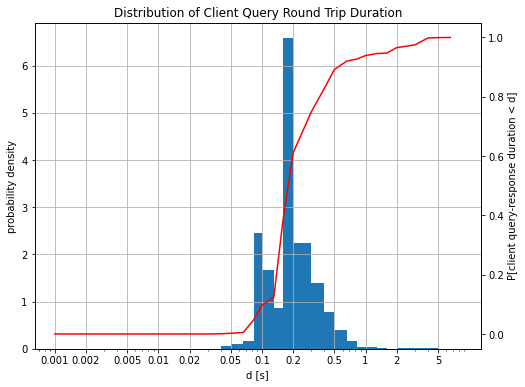

In [123]:
# client query duration distribution

queries['duration'] = queries['finished'] - queries['started']

data = queries['duration'].astype(np.float).dropna()
bins = [b*10**p for p in [-3, -2, -1, 0] for b in [1,1.3,1.6,2,3,4,5,6.6,8.3]]
labels = bins[::3]
hist, bin_edges = np.histogram(data, bins=bins)
cdf = np.cumsum(hist)

plt.figure(figsize=(8, 6))
plt.grid(True)

ax, tax = plt.gca(), plt.twinx()

ax.hist(data, bins=bins, density=True)
ax.set_ylabel('probability density')
ax.set_xlabel('d [s]')

tax.plot(bin_edges[:-1], cdf/cdf[-1], c='r')
tax.set_ylabel('P[client query-response duration < d]')

plt.xscale('log')
plt.xticks(labels, map(str, labels))
plt.title('Distribution of Client Query Round Trip Duration')

None

In [124]:
# show a single query to the server

for p in queries.iloc[200]['server_packets']:
    if p[DNS].qr != 0:
        continue
    print(p[IP].show())

###[ IP ]### 
  version   = 4
  ihl       = 5
  tos       = 0x0
  len       = 107
  id        = 40495
  flags     = DF
  frag      = 0
  ttl       = 57
  proto     = udp
  chksum    = 0x44d3
  src       = 162.158.82.254
  dst       = 130.149.230.77
  \options   \
###[ UDP ]### 
     sport     = 12474
     dport     = domain
     len       = 87
     chksum    = 0xbc0b
###[ DNS ]### 
        id        = 45228
        qr        = 0
        opcode    = QUERY
        aa        = 0
        tc        = 0
        rd        = 0
        ra        = 0
        z         = 0
        ad        = 0
        cd        = 0
        rcode     = ok
        qdcount   = 1
        ancount   = 0
        nscount   = 0
        arcount   = 1
        \qd        \
         |###[ DNS Question Record ]### 
         |  qname     = 'opn-cloudflare-20210617014323.unsigned.8.dnstb.net.'
         |  qtype     = A
         |  qclass    = IN
        an        = None
        ns        = None
        \ar        \
         |##